In [1]:
!gsutil cp gs://rebecca-summer23/cd138_adata_MOREHVG_noIG.h5ad /tmp

Copying gs://rebecca-summer23/cd138_adata_MOREHVG_noIG.h5ad...
/ [1 files][  3.5 GiB/  3.5 GiB]   76.7 MiB/s                                   
Operation completed over 1 objects/3.5 GiB.                                      


In [1]:
import mrvi
import anndata
import scanpy as sc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

/home/boiarskr/GitLab/cancer-sc-embed/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/boiarskr/GitLab/cancer-sc-embed/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
torch.cuda.is_available()

True

## load Boiarsky et al MM data

In [3]:
cd138_adata = sc.read_h5ad("/tmp/cd138_adata_MOREHVG_noIG.h5ad")

# mrVI with CNV regressed out of u

In [6]:
# read in pickled results
!gsutil cp gs://rebecca-summer23/outputs/cnv_array_cd138.pkl /tmp

Copying gs://rebecca-summer23/outputs/cnv_array_cd138.pkl...
/ [1 files][  4.9 GiB/  4.9 GiB]   80.9 MiB/s                                   
Operation completed over 1 objects/4.9 GiB.                                      


In [7]:
file = open('/tmp/cnv_array_cd138.pkl', 'rb')

# dump information to that file
cnv_array = pickle.load(file)

# close the file
file.close()

In [8]:
cd138_adata.obsm['cnv'] = cnv_array

In [9]:
mrvi.MrVI.setup_anndata(cd138_adata, layer="counts", cnv_key="cnv")

INFO     Generating sequential column names                                                                        


In [10]:
mrvi_model = mrvi.MrVI(cd138_adata)

In [11]:
mrvi_model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 272/272: 100%|██████████| 272/272 [57:25<00:00, 12.42s/it, v_num=1, train_loss_step=2.78e+4, train_loss_epoch=2.9e+4]

`Trainer.fit` stopped: `max_epochs=272` reached.


Epoch 272/272: 100%|██████████| 272/272 [57:25<00:00, 12.67s/it, v_num=1, train_loss_step=2.78e+4, train_loss_epoch=2.9e+4]


In [13]:
#pickle mrvi sample=person results
import pickle 

# open a file, where you ant to store the data
file = open('outputs/mrvi_cnv_cd138.pkl', 'wb')

# dump information to that file
pickle.dump(mrvi_model, file)

# close the file
file.close()


In [ ]:
#load saved model
import pickle 

file = open('outputs/mrvi_cnv_cd138.pkl', 'rb')

# dump information to that file
mrvi_model = pickle.load(file)

# close the file
file.close()

In [14]:
# Get z representation
cd138_adata.obsm["X_mrvi_z"] = mrvi_model.get_latent_representation(give_z=True)
# Get u representation
cd138_adata.obsm["X_mrvi_u"] = mrvi_model.get_latent_representation(give_z=False)


100%|██████████| 230/230 [00:22<00:00, 10.33it/s]


/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/umap/dist

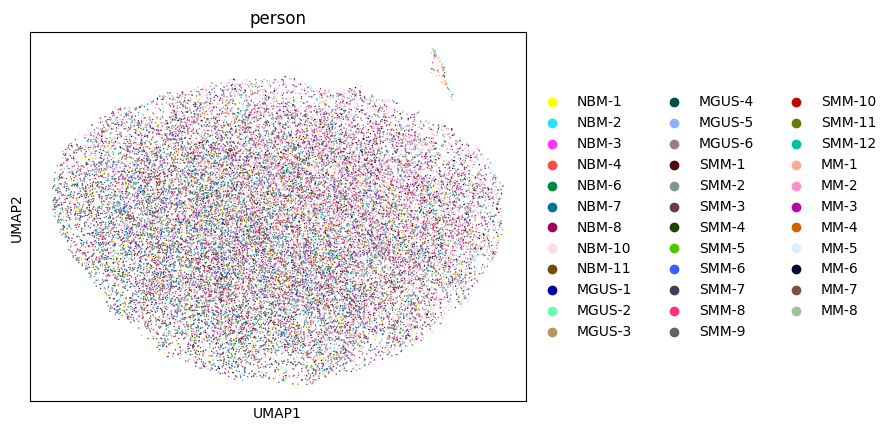

In [15]:
sc.pp.neighbors(cd138_adata, use_rep="X_mrvi_z")
sc.tl.umap(cd138_adata)
sc.pl.umap(cd138_adata, color="person")

/home/boiarskr/anaconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


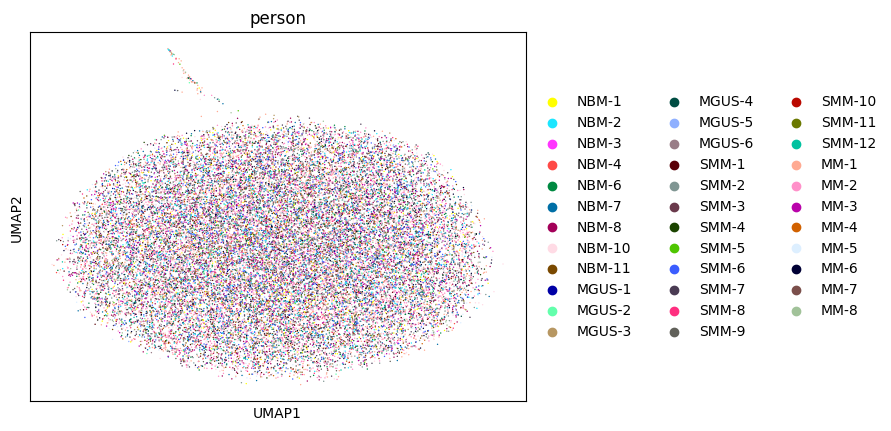

In [16]:
sc.pp.neighbors(cd138_adata, use_rep="X_mrvi_u")
sc.tl.umap(cd138_adata)
sc.pl.umap(cd138_adata, color="person")